<a href="https://colab.research.google.com/github/piotrciechowicz/fake_news_detection/blob/main/Fake_news_detection_DS_Fake%26Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score

!pip install pandas-profiling
from pandas_profiling import ProfileReport
from pathlib import Path
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-1-fcb097f69733>:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Functions

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(texts):
    output= [i for i in texts if i not in stopwords]
    return output

In [3]:
interpunction = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', ':', ';', '<', '=', '>', '?', '@', '[', '', ']', '^', '_', '`', '{', '|', '}', '~']
def remove_interpunction(texts):
    output= [i for i in texts if i not in interpunction]
    return output

In [4]:
lemmatizer = WordNetLemmatizer()
def lemmatize(texts):
    lem_text = [lemmatizer.lemmatize(word) for word in texts]
    return lem_text

In [5]:
def test_model(X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0


  with torch.no_grad():
    correct_test = 0
    total_test = 0
    outputs_test = torch.squeeze(model(X_test))
    loss_test = criterion(outputs_test, y_test)

    predicted_test = outputs_test.round().detach().numpy()
    total_test += y_test.size(0)
    correct_test += np.sum(predicted_test == y_test.detach().numpy())
    accuracy_test = 100 * correct_test/total_test
    losses_test.append(loss_test.item())

    print(f"Test - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")

In [6]:
def use_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0

  for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
      x = X_train
      labels = y_train
      optimizer.zero_grad() 
      outputs = model(X_train)
      loss = criterion(torch.squeeze(outputs), labels) 
      
      loss.backward() 
      
      optimizer.step() 
      
      iter+=1
      if iter%(epochs/5)==0:
          with torch.no_grad():
              correct_test = 0
              total_test = 0
              outputs_test = torch.squeeze(model(X_test))
              loss_test = criterion(outputs_test, y_test)
              
              predicted_test = outputs_test.round().detach().numpy()
              total_test += y_test.size(0)
              correct_test += np.sum(predicted_test == y_test.detach().numpy())
              accuracy_test = 100 * correct_test/total_test
              losses_test.append(loss_test.item())
              total = 0
              correct = 0
              total += y_train.size(0)
              correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
              accuracy = 100 * correct/total
              losses.append(loss.item())
              Iterations.append(iter)

              print(f"Iteration: {iter}. \nVal - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
              print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
  return accuracy

In [7]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [8]:
def validation_with_StratifiedKFold(X_train, y_train, X_val, y_val, X_test, y_test, 
                                    n_splits, model, criterion, optimizer, epochs):

  skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 8)

  for fold,(train_idx,test_idx) in enumerate(skf.split(X_train, y_train)):

    print('\n')   
    print('------------fold no---------{}----------------------'.format(fold))
    print('\n')   

    x_train_fold, x_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    model_lr.apply(reset_weights)
    
    print('\n')    
    print('Fit model on train part of dataset')
    print('\n')  
    use_model(x_train_fold, y_train_fold, x_test_fold, y_test_fold, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on validation part of dataset')
    print('\n')  
    test_model(X_val, y_val, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on test part of dataset')
    print('\n') 
    test_model(X_test, y_test, 
               model, criterion, 
               optimizer, epochs)

#Importing dataset

In [9]:
path_fake = '/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/Fake & Real/Fake.csv'
fake = pd.read_csv(path_fake)
path_true = '/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/Fake & Real/True.csv'
true = pd.read_csv(path_true)

In [10]:
fake['true/fake'] = 'Fake'
true['true/fake'] = 'True'

In [11]:
fake.sample(3)

,title,text,subject,date,true/fake
16771,BREAKING UPDATE…Last Holdout: “I DECLARE WAR A...,Negotiations to surrender currently live-strea...,Government News,"Feb 10, 2016",Fake
13278,PRICELESS! UNHINGED FEMINIST Goes Ballistic On...,A feminist supporter of Hillary Clinton was on...,politics,"Aug 11, 2016",Fake
186,Milo Yiannopoulos Tells Aussies To Vote Again...,Milo Yiannopoulos will do anything to keep his...,News,"October 26, 2017",Fake


In [12]:
true.sample(3)

,title,text,subject,date,true/fake
14477,Hariri tells Lebanese president will be in Leb...,"BEIRUT (Reuters) - Saad al-Hariri, who resigne...",worldnews,"November 18, 2017",True
2573,Kremlin: U.S. arms supplies to Ukraine would s...,MOSCOW (Reuters) - Any U.S. decision to supply...,politicsNews,"July 25, 2017",True
4552,Trump to host Jordan's King Abdullah on April ...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"March 31, 2017",True


# Exploratory data analysis

In [13]:
df = pd.concat([true,fake], ignore_index = True)

In [14]:
df_2 = df.drop(['date','subject'],axis=1)

In [15]:
print('Shape:')
print(df_2.shape)
print('-'*80, '\n')
print('Duplicates:')
print(df_2.duplicated().sum())
print('-'*80, '\n')
print('Missing values:')
print(df_2.isnull().sum())
print('-'*80, '\n')

Shape:
(44898, 3)
-------------------------------------------------------------------------------- 

Duplicates:
5793
-------------------------------------------------------------------------------- 

Missing values:
title        0
text         0
true/fake    0
dtype: int64
-------------------------------------------------------------------------------- 



In [16]:
df_2 = df_2.drop_duplicates()

True    21197
Fake    17908
Name: true/fake, dtype: int64
-------------------------------------------------------------------------------- 



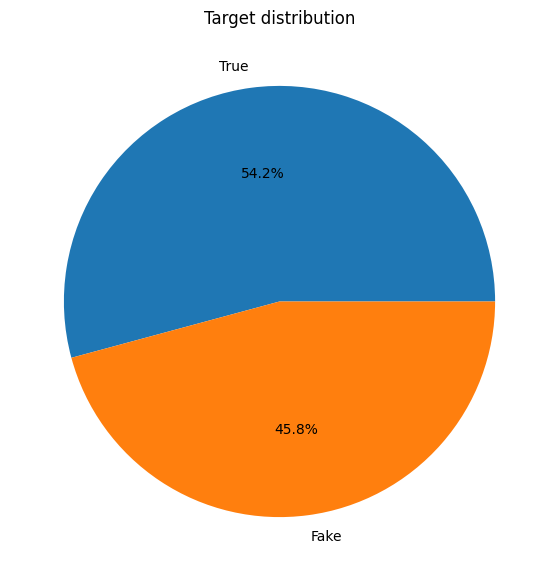

In [17]:
print(df_2['true/fake'].value_counts())
print('-'*80, '\n')
fig, ax = plt.subplots(figsize = (7,7))
ax.pie(df_2['true/fake'].value_counts(),labels=['True','Fake'], autopct='%1.1f%%')
ax.set_title('Target distribution')
plt.show()

#Pandas profiling

In [18]:
prof = ProfileReport(df_2)
prof.to_file(Path("/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/pandas_profiling_report_fake_and_real.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#Feature engeneering

##Downsampling

In [19]:
df_2_fake = df_2[df_2['true/fake']=='Fake']
df_2_true = df_2[df_2['true/fake']=='True']

In [20]:
df_2_true_downsample = resample(df_2_true,
             replace=True,
             n_samples=len(df_2_fake),
             random_state=42)

In [21]:
data = pd.concat([df_2_true_downsample,df_2_fake], ignore_index = True)

In [22]:
print(data['true/fake'].value_counts())
print('-'*80, '\n')

True    17908
Fake    17908
Name: true/fake, dtype: int64
-------------------------------------------------------------------------------- 



In [23]:
data = data.replace({'true/fake' : {'True' : 1, 'Fake' : 0}},inplace=False)

In [24]:
data = data.rename({'true/fake': 'is_real'}, axis='columns')

In [25]:
X_0 = data['title'] + data['text']
y = data['is_real']

##Lowering the text

In [26]:
X_low = X_0.map(lambda x: x.lower())

##Tokenization

In [27]:
X_tokenize = X_low.map(lambda x: word_tokenize(x))

##Removing stopwords

In [28]:
X_stopwords = X_tokenize.map(lambda x: remove_stopwords(x))

##Removing interpuntion

In [29]:
X_interpunction = X_stopwords.map(lambda x: remove_interpunction(x))

##Converting words to lemma

In [30]:
X_lemmatize = X_interpunction.map(lambda x: lemmatize(x))

#WordCloud

In [31]:
X = X_lemmatize.astype(str)

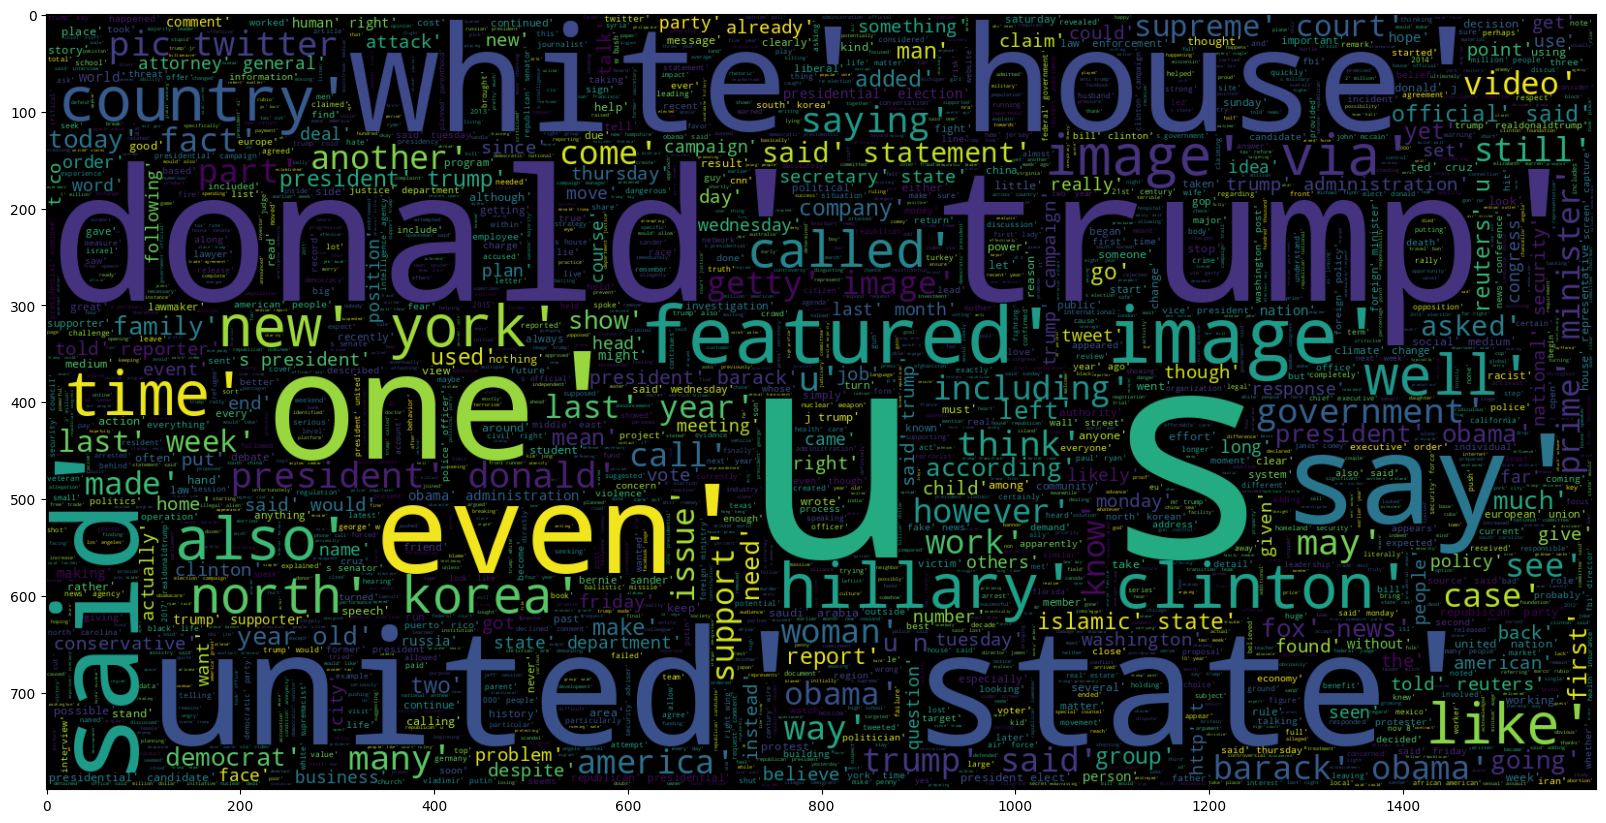

In [32]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(X))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

#Modeling

##Split dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8, random_state = 8, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 8, stratify=y_test)

##TfidfVectorizer

In [34]:
tfidf = TfidfVectorizer(max_features=100)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

#Logistic Regression with PyTorch

###Model logistic regression

In [35]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [36]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
learning_rate = 0.01

In [37]:
model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

In [38]:
X_train_py, X_val_py, X_test_py = torch.Tensor(X_train_tfidf.toarray()),torch.Tensor(X_val_tfidf.toarray()),torch.Tensor(X_test_tfidf.toarray())
y_train_py, y_val_py, y_test_py = torch.Tensor(y_train.to_numpy()),torch.Tensor(y_val.to_numpy()),torch.Tensor(y_test.to_numpy())

In [39]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

Training Epochs:  21%|██▏       | 2126/10000 [00:02<00:09, 815.43it/s]

Iteration: 2000. 
Val - Loss: 0.5731214284896851. Accuracy: 89.64891463669994
Train -  Loss: 0.5747236013412476. Accuracy: 89.19447159011587



Training Epochs:  41%|████      | 4077/10000 [00:05<00:10, 563.04it/s]

Iteration: 4000. 
Val - Loss: 0.4969042241573334. Accuracy: 91.07279960912962
Train -  Loss: 0.4988054931163788. Accuracy: 90.79994415747592



Training Epochs:  61%|██████    | 6056/10000 [00:09<00:07, 543.37it/s]

Iteration: 6000. 
Val - Loss: 0.4429472088813782. Accuracy: 91.76380261045578
Train -  Loss: 0.444882869720459. Accuracy: 91.6794639117688



Training Epochs:  82%|████████▏ | 8158/10000 [00:12<00:02, 846.31it/s]

Iteration: 8000. 
Val - Loss: 0.402851402759552. Accuracy: 92.20353179311789
Train -  Loss: 0.40468329191207886. Accuracy: 92.3076923076923



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 669.12it/s]

Iteration: 10000. 
Val - Loss: 0.37185341119766235. Accuracy: 92.77587771340825
Train -  Loss: 0.3735112249851227. Accuracy: 92.8102750244311



92.8102750244311

###Optuna

In [40]:
def objective(trial):

  input_dim = X_train_tfidf.shape[1]
  output_dim = 1

  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}

  model_lr = LogisticRegression(input_dim,output_dim)
  criterion_lr = torch.nn.BCELoss()
  optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

  accuracy = use_model(X_train_py, y_train_py, X_val_py, y_val_py, 
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

  return accuracy

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=600)

[I 2023-04-17 16:26:28,030] A new study created in memory with name: no-name-328ad4f6-2a27-4cc7-bb5b-f6d1c293630e
<ipython-input-40-eca541b33e7e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}
Training Epochs:  21%|██        | 2090/10000 [00:02<00:09, 851.75it/s]

Iteration: 2000. 
Val - Loss: 0.5792906880378723. Accuracy: 90.34689746632233
Train -  Loss: 0.5802798271179199. Accuracy: 89.97626692726512



Training Epochs:  41%|████▏     | 4136/10000 [00:04<00:06, 866.50it/s]

Iteration: 4000. 
Val - Loss: 0.500907301902771. Accuracy: 91.34501291268235
Train -  Loss: 0.5023746490478516. Accuracy: 91.1629205640095



Training Epochs:  61%|██████    | 6062/10000 [00:07<00:05, 683.55it/s]

Iteration: 6000. 
Val - Loss: 0.44570788741111755. Accuracy: 91.86152020660292
Train -  Loss: 0.44733333587646484. Accuracy: 91.81907022197403



Training Epochs:  81%|████████  | 8077/10000 [00:10<00:03, 589.78it/s]

Iteration: 8000. 
Val - Loss: 0.40484875440597534. Accuracy: 92.35708801563482
Train -  Loss: 0.4064579904079437. Accuracy: 92.41937735585648



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 711.80it/s]
[I 2023-04-17 16:26:42,092] Trial 0 finished with value: 92.90799944157476 and parameters: {'lr': 0.04675247056346309}. Best is trial 0 with value: 92.90799944157476.


Iteration: 10000. 
Val - Loss: 0.37335005402565. Accuracy: 92.86661548125916
Train -  Loss: 0.37484902143478394. Accuracy: 92.90799944157476



Training Epochs:  21%|██        | 2114/10000 [00:02<00:09, 846.46it/s]

Iteration: 2000. 
Val - Loss: 0.5727378726005554. Accuracy: 90.66796956794863
Train -  Loss: 0.5734055638313293. Accuracy: 90.6044953231886



Training Epochs:  41%|████      | 4124/10000 [00:05<00:06, 854.56it/s]

Iteration: 4000. 
Val - Loss: 0.49637240171432495. Accuracy: 91.51950862008795
Train -  Loss: 0.49754947423934937. Accuracy: 91.52589697054307



Training Epochs:  61%|██████    | 6115/10000 [00:07<00:04, 900.14it/s]

Iteration: 6000. 
Val - Loss: 0.4424438178539276. Accuracy: 92.07091505548964
Train -  Loss: 0.4438050091266632. Accuracy: 91.9865977942203



Training Epochs:  81%|████████▏ | 8132/10000 [00:09<00:02, 880.42it/s]

Iteration: 8000. 
Val - Loss: 0.40241408348083496. Accuracy: 92.51762406644796
Train -  Loss: 0.4037809371948242. Accuracy: 92.433337986877



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 806.90it/s]
[I 2023-04-17 16:26:54,500] Trial 1 finished with value: 92.83819628647215 and parameters: {'lr': 0.0648076445218947}. Best is trial 0 with value: 92.90799944157476.


Iteration: 10000. 
Val - Loss: 0.3714771270751953. Accuracy: 92.84567599637049
Train -  Loss: 0.37275195121765137. Accuracy: 92.83819628647215



Training Epochs:  21%|██        | 2105/10000 [00:03<00:14, 544.78it/s]

Iteration: 2000. 
Val - Loss: 0.5761223435401917. Accuracy: 89.9560270817338
Train -  Loss: 0.5773559808731079. Accuracy: 89.36199916236214



Training Epochs:  41%|████      | 4059/10000 [00:07<00:10, 547.58it/s]

Iteration: 4000. 
Val - Loss: 0.4989045262336731. Accuracy: 91.07279960912962
Train -  Loss: 0.5005297660827637. Accuracy: 90.9116292056401



Training Epochs:  61%|██████    | 6115/10000 [00:09<00:04, 878.67it/s]

Iteration: 6000. 
Val - Loss: 0.4443305432796478. Accuracy: 91.83360089341802
Train -  Loss: 0.4460570216178894. Accuracy: 91.6794639117688



Training Epochs:  82%|████████▏ | 8167/10000 [00:12<00:02, 882.34it/s]

Iteration: 8000. 
Val - Loss: 0.40383514761924744. Accuracy: 92.51762406644796
Train -  Loss: 0.405507892370224. Accuracy: 92.39145609381544



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 706.35it/s]
[I 2023-04-17 16:27:08,666] Trial 2 finished with value: 92.75443250034901 and parameters: {'lr': 0.07016386358918694}. Best is trial 0 with value: 92.90799944157476.


Iteration: 10000. 
Val - Loss: 0.3725656569004059. Accuracy: 92.97829273399874
Train -  Loss: 0.3741030991077423. Accuracy: 92.75443250034901



Training Epochs:  21%|██        | 2121/10000 [00:02<00:08, 879.22it/s]

Iteration: 2000. 
Val - Loss: 0.5815300941467285. Accuracy: 89.57213652544148
Train -  Loss: 0.5826539993286133. Accuracy: 89.30615663828004



Training Epochs:  41%|████      | 4088/10000 [00:05<00:10, 566.41it/s]

Iteration: 4000. 
Val - Loss: 0.5024861693382263. Accuracy: 91.1844768618692
Train -  Loss: 0.5040121078491211. Accuracy: 90.88370794359905



Training Epochs:  61%|██████    | 6111/10000 [00:08<00:06, 576.42it/s]

Iteration: 6000. 
Val - Loss: 0.44678741693496704. Accuracy: 91.81266140852935
Train -  Loss: 0.44841670989990234. Accuracy: 91.69342454278933



Training Epochs:  81%|████████  | 8094/10000 [00:12<00:02, 786.49it/s]

Iteration: 8000. 
Val - Loss: 0.40556880831718445. Accuracy: 92.40594681370838
Train -  Loss: 0.40714287757873535. Accuracy: 92.27977104565126



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 691.86it/s]
[I 2023-04-17 16:27:23,133] Trial 3 finished with value: 92.76839313136954 and parameters: {'lr': 0.035732966685856404}. Best is trial 0 with value: 92.90799944157476.


Iteration: 10000. 
Val - Loss: 0.3738136291503906. Accuracy: 92.83869616807426
Train -  Loss: 0.3752496838569641. Accuracy: 92.76839313136954



Training Epochs:  21%|██        | 2105/10000 [00:02<00:09, 851.95it/s]

Iteration: 2000. 
Val - Loss: 0.5743809342384338. Accuracy: 90.95414252809381
Train -  Loss: 0.5752250552177429. Accuracy: 90.64637721625017



Training Epochs:  41%|████▏     | 4148/10000 [00:04<00:06, 867.82it/s]

Iteration: 4000. 
Val - Loss: 0.497415155172348. Accuracy: 91.60326655964263
Train -  Loss: 0.4987369179725647. Accuracy: 91.47005444646098



Training Epochs:  61%|██████    | 6119/10000 [00:07<00:04, 866.44it/s]

Iteration: 6000. 
Val - Loss: 0.44308117032051086. Accuracy: 92.10581419697075
Train -  Loss: 0.4445646107196808. Accuracy: 91.9307552701382



Training Epochs:  81%|████████  | 8087/10000 [00:10<00:03, 607.98it/s]

Iteration: 8000. 
Val - Loss: 0.4027828872203827. Accuracy: 92.60836183429888
Train -  Loss: 0.4042554199695587. Accuracy: 92.41937735585648



Training Epochs: 100%|██████████| 10000/10000 [00:13<00:00, 728.97it/s]
[I 2023-04-17 16:27:36,863] Trial 4 finished with value: 92.88007817953371 and parameters: {'lr': 0.03121320998528903}. Best is trial 0 with value: 92.90799944157476.


Iteration: 10000. 
Val - Loss: 0.37166857719421387. Accuracy: 93.03413136036853
Train -  Loss: 0.3730367124080658. Accuracy: 92.88007817953371



In [42]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 92.90799944157476
  Params: 
    lr: 0.04675247056346309


###StratifiedKFold

In [43]:
lr_best = trial.params['lr']
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [44]:
validation_with_StratifiedKFold(X_train_py, y_train_py,
                                X_val_py, y_val_py, 
                                X_test_py, y_test_py, 
                                n_splits = 5, model = model_lr, 
                                criterion = criterion_lr, optimizer = optimizer_lr, epochs = 10000)



------------fold no---------0----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  20%|██        | 2006/10000 [00:03<00:21, 368.70it/s]

Iteration: 2000. 
Val - Loss: 0.38048112392425537. Accuracy: 92.88206559665038
Train -  Loss: 0.3866320848464966. Accuracy: 92.26876090750436



Training Epochs:  42%|████▏     | 4194/10000 [00:09<00:06, 956.40it/s]

Iteration: 4000. 
Val - Loss: 0.28682824969291687. Accuracy: 94.55687369155618
Train -  Loss: 0.29462045431137085. Accuracy: 94.13612565445027



Training Epochs:  62%|██████▏   | 6173/10000 [00:11<00:03, 1017.60it/s]

Iteration: 6000. 
Val - Loss: 0.2403925657272339. Accuracy: 95.0453593859037
Train -  Loss: 0.2488483041524887. Accuracy: 94.79930191972076



Training Epochs:  81%|████████  | 8098/10000 [00:14<00:02, 686.82it/s]

Iteration: 8000. 
Val - Loss: 0.21186797320842743. Accuracy: 95.67341242149337
Train -  Loss: 0.22059573233127594. Accuracy: 95.21815008726003



Training Epochs: 100%|██████████| 10000/10000 [00:17<00:00, 584.63it/s]


Iteration: 10000. 
Val - Loss: 0.19219212234020233. Accuracy: 95.67341242149337
Train -  Loss: 0.20100732147693634. Accuracy: 95.54973821989529



Evaluation model on validation part of dataset


Test - Loss: 0.20073099434375763. Accuracy: 95.42123263767711


Evaluation model on test part of dataset


Test - Loss: 0.20207491517066956. Accuracy: 95.18358229791987


------------fold no---------1----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2115/10000 [00:03<00:11, 667.81it/s]

Iteration: 2000. 
Val - Loss: 0.38543403148651123. Accuracy: 93.23098394975575
Train -  Loss: 0.3815613389015198. Accuracy: 92.72251308900523



Training Epochs:  42%|████▏     | 4184/10000 [00:05<00:05, 999.51it/s]

Iteration: 4000. 
Val - Loss: 0.29412972927093506. Accuracy: 94.4870900209351
Train -  Loss: 0.29032355546951294. Accuracy: 94.27574171029669



Training Epochs:  61%|██████▏   | 6131/10000 [00:07<00:03, 1015.18it/s]

Iteration: 6000. 
Val - Loss: 0.24859555065631866. Accuracy: 95.18492672714585
Train -  Loss: 0.24510207772254944. Accuracy: 94.90401396160559



Training Epochs:  82%|████████▏ | 8201/10000 [00:09<00:01, 1021.19it/s]

Iteration: 8000. 
Val - Loss: 0.22048147022724152. Accuracy: 95.39427773900907
Train -  Loss: 0.21722227334976196. Accuracy: 95.25305410122164



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 882.22it/s]


Iteration: 10000. 
Val - Loss: 0.20101267099380493. Accuracy: 95.8827634333566
Train -  Loss: 0.19790354371070862. Accuracy: 95.35776614310646



Evaluation model on validation part of dataset


Test - Loss: 0.19997507333755493. Accuracy: 95.42821246597333


Evaluation model on test part of dataset


Test - Loss: 0.2013191431760788. Accuracy: 95.23244450649169


------------fold no---------2----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  22%|██▏       | 2168/10000 [00:02<00:07, 1014.54it/s]

Iteration: 2000. 
Val - Loss: 0.38475915789604187. Accuracy: 92.46336357292394
Train -  Loss: 0.3824620246887207. Accuracy: 92.79232111692845



Training Epochs:  41%|████      | 4107/10000 [00:04<00:08, 691.58it/s]

Iteration: 4000. 
Val - Loss: 0.29504039883613586. Accuracy: 93.71946964410328
Train -  Loss: 0.2905728220939636. Accuracy: 94.25828970331588



Training Epochs:  61%|██████    | 6079/10000 [00:07<00:06, 652.11it/s]

Iteration: 6000. 
Val - Loss: 0.2508368194103241. Accuracy: 94.4870900209351
Train -  Loss: 0.2448623776435852. Accuracy: 95.07853403141361



Training Epochs:  81%|████████  | 8066/10000 [00:10<00:03, 630.64it/s]

Iteration: 8000. 
Val - Loss: 0.22372283041477203. Accuracy: 94.62665736217726
Train -  Loss: 0.21665586531162262. Accuracy: 95.37521815008726



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 786.02it/s]


Iteration: 10000. 
Val - Loss: 0.2050037533044815. Accuracy: 94.97557571528263
Train -  Loss: 0.19710776209831238. Accuracy: 95.5846422338569



Evaluation model on validation part of dataset


Test - Loss: 0.19995805621147156. Accuracy: 95.33747469812242


Evaluation model on test part of dataset


Test - Loss: 0.20155900716781616. Accuracy: 95.12075945832751


------------fold no---------3----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  22%|██▏       | 2152/10000 [00:02<00:07, 1017.54it/s]

Iteration: 2000. 
Val - Loss: 0.3849455714225769. Accuracy: 91.75977653631286
Train -  Loss: 0.38483667373657227. Accuracy: 92.72378293491538



Training Epochs:  42%|████▏     | 4179/10000 [00:04<00:05, 977.01it/s]

Iteration: 4000. 
Val - Loss: 0.2929128408432007. Accuracy: 93.50558659217877
Train -  Loss: 0.29223307967185974. Accuracy: 94.294189495725



Training Epochs:  62%|██████▏   | 6187/10000 [00:06<00:03, 1018.34it/s]

Iteration: 6000. 
Val - Loss: 0.24761547148227692. Accuracy: 94.34357541899442
Train -  Loss: 0.24617068469524384. Accuracy: 95.07939277612982



Training Epochs:  81%|████████▏ | 8142/10000 [00:08<00:01, 948.31it/s] 

Iteration: 8000. 
Val - Loss: 0.21991977095603943. Accuracy: 94.62290502793296
Train -  Loss: 0.2177530974149704. Accuracy: 95.39347408829174



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 915.01it/s]


Iteration: 10000. 
Val - Loss: 0.20087175071239471. Accuracy: 94.6927374301676
Train -  Loss: 0.198061004281044. Accuracy: 95.56796370615949



Evaluation model on validation part of dataset


Test - Loss: 0.19980764389038086. Accuracy: 95.38633349619599


Evaluation model on test part of dataset


Test - Loss: 0.20118269324302673. Accuracy: 95.23244450649169


------------fold no---------4----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2124/10000 [00:03<00:12, 627.13it/s]

Iteration: 2000. 
Val - Loss: 0.38947203755378723. Accuracy: 92.59776536312849
Train -  Loss: 0.3826234042644501. Accuracy: 92.74123189670215



Training Epochs:  41%|████      | 4100/10000 [00:06<00:06, 906.61it/s]

Iteration: 4000. 
Val - Loss: 0.29863491654396057. Accuracy: 93.78491620111731
Train -  Loss: 0.29017287492752075. Accuracy: 94.22439364857792



Training Epochs:  62%|██████▏   | 6196/10000 [00:08<00:03, 1037.74it/s]

Iteration: 6000. 
Val - Loss: 0.25345468521118164. Accuracy: 95.04189944134079
Train -  Loss: 0.24469442665576935. Accuracy: 94.83510731111498



Training Epochs:  82%|████████▏ | 8185/10000 [00:10<00:01, 1009.63it/s]

Iteration: 8000. 
Val - Loss: 0.22544261813163757. Accuracy: 95.4608938547486
Train -  Loss: 0.21680641174316406. Accuracy: 95.13173966149014



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 844.89it/s]

Iteration: 10000. 
Val - Loss: 0.20590907335281372. Accuracy: 95.67039106145252
Train -  Loss: 0.19754989445209503. Accuracy: 95.27133135578433



Evaluation model on validation part of dataset


Test - Loss: 0.20071038603782654. Accuracy: 95.25371675856773


Evaluation model on test part of dataset


Test - Loss: 0.2020304799079895. Accuracy: 95.03699567220438


###Without cutting "stopwords'

In [45]:
X_interpunction_2 = X_tokenize.map(lambda x: remove_interpunction(x))
X_lemmatize_2 = X_interpunction_2.map(lambda x: lemmatize(x))
X_2 = X_lemmatize_2.astype(str)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_2 = tfidf.fit_transform(X_train_2)
X_val_tfidf_2 = tfidf.transform(X_val_2)

In [46]:
input_dim = X_train_tfidf_2.shape[1]
output_dim = 1
lr = lr_best

model_lr_2 = LogisticRegression(input_dim,output_dim)
criterion_lr_2 = torch.nn.BCELoss()
optimizer_lr_2 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [47]:
X_train_py_2, X_val_py_2 = torch.Tensor(X_train_tfidf_2.toarray()),torch.Tensor(X_val_tfidf_2.toarray())
y_train_py_2, y_val_py_2 = torch.Tensor(y_train_2.to_numpy()),torch.Tensor(y_val_2.to_numpy())

In [48]:
use_model(X_train_py_2, y_train_py_2, X_val_py_2, y_val_py_2,
          model = model_lr_2, criterion = criterion_lr_2, 
          optimizer = optimizer_lr_2, epochs = 10000)

Training Epochs:  21%|██        | 2111/10000 [00:02<00:09, 875.33it/s]

Iteration: 2000. 
Val - Loss: 0.6945855617523193. Accuracy: 47.90772344955153
Train -  Loss: 0.6947948932647705. Accuracy: 46.879798966913306



Training Epochs:  41%|████      | 4116/10000 [00:04<00:06, 913.83it/s]

Iteration: 4000. 
Val - Loss: 0.6945855617523193. Accuracy: 47.90772344955153
Train -  Loss: 0.6947948932647705. Accuracy: 46.879798966913306



Training Epochs:  62%|██████▏   | 6163/10000 [00:06<00:04, 891.72it/s]

Iteration: 6000. 
Val - Loss: 0.6945855617523193. Accuracy: 47.90772344955153
Train -  Loss: 0.6947948932647705. Accuracy: 46.879798966913306



Training Epochs:  81%|████████  | 8123/10000 [00:09<00:02, 895.64it/s]

Iteration: 8000. 
Val - Loss: 0.6945855617523193. Accuracy: 47.90772344955153
Train -  Loss: 0.6947948932647705. Accuracy: 46.879798966913306



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 875.03it/s]

Iteration: 10000. 
Val - Loss: 0.6945855617523193. Accuracy: 47.90772344955153
Train -  Loss: 0.6947948932647705. Accuracy: 46.879798966913306



46.879798966913306

###Without lemmatization

In [49]:
X_3 = X_interpunction.astype(str)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_3 = tfidf.fit_transform(X_train_3)
X_val_tfidf_3 = tfidf.transform(X_val_3)

In [50]:
input_dim = X_train_tfidf_3.shape[1]
output_dim = 1
lr = lr_best

model_lr_3 = LogisticRegression(input_dim,output_dim)
criterion_lr_3 = torch.nn.BCELoss()
optimizer_lr_3 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [51]:
X_train_py_3, X_val_py_3 = torch.Tensor(X_train_tfidf_3.toarray()),torch.Tensor(X_val_tfidf_3.toarray())
y_train_py_3, y_val_py_3 = torch.Tensor(y_train_3.to_numpy()),torch.Tensor(y_val_3.to_numpy())

In [52]:
use_model(X_train_py_3, y_train_py_3, X_val_py_3, y_val_py_3,
          model = model_lr_3, criterion = criterion_lr_3, 
          optimizer = optimizer_lr_3, epochs = 10000)

Training Epochs:  21%|██▏       | 2140/10000 [00:02<00:08, 898.82it/s]

Iteration: 2000. 
Val - Loss: 0.7050073742866516. Accuracy: 45.00750357728685
Train -  Loss: 0.7045772075653076. Accuracy: 45.009074410163336



Training Epochs:  41%|████      | 4079/10000 [00:04<00:08, 690.87it/s]

Iteration: 4000. 
Val - Loss: 0.7050073742866516. Accuracy: 45.00750357728685
Train -  Loss: 0.7045772075653076. Accuracy: 45.009074410163336



Training Epochs:  61%|██████    | 6071/10000 [00:07<00:06, 627.77it/s]

Iteration: 6000. 
Val - Loss: 0.7050073742866516. Accuracy: 45.00750357728685
Train -  Loss: 0.7045772075653076. Accuracy: 45.009074410163336



Training Epochs:  81%|████████  | 8118/10000 [00:11<00:03, 604.13it/s]

Iteration: 8000. 
Val - Loss: 0.7050073742866516. Accuracy: 45.00750357728685
Train -  Loss: 0.7045772075653076. Accuracy: 45.009074410163336



Training Epochs: 100%|██████████| 10000/10000 [00:13<00:00, 728.21it/s]

Iteration: 10000. 
Val - Loss: 0.7050073742866516. Accuracy: 45.00750357728685
Train -  Loss: 0.7045772075653076. Accuracy: 45.009074410163336



45.009074410163336

#Deeper neutral network

In [53]:
class DeeperNN(nn.Module):

  def __init__(self, input_dim, output_dim):
      super().__init__()
      self.layer1 = nn.Linear(input_dim, 60)
      self.act1 = nn.ReLU()
      self.layer2 = nn.Linear(60, 60)
      self.act2 = nn.ReLU()
      self.layer3 = nn.Linear(60, 60)
      self.act3 = nn.ReLU()
      self.output = nn.Linear(60, output_dim)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.act1(self.layer1(x))
      x = self.act2(self.layer2(x))
      x = self.act3(self.layer3(x))
      x = self.sigmoid(self.output(x))
      return x

In [54]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_nn = DeeperNN(input_dim,output_dim)
criterion_nn = torch.nn.BCELoss()
optimizer_nn = torch.optim.SGD(model_nn.parameters(), lr=lr)

In [55]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_nn, criterion = criterion_nn, 
          optimizer = optimizer_nn, epochs = 10000)

Training Epochs:  20%|██        | 2007/10000 [00:40<02:23, 55.59it/s]

Iteration: 2000. 
Val - Loss: 0.060286182910203934. Accuracy: 98.18524464298179
Train -  Loss: 0.05288443714380264. Accuracy: 98.46433058774257



Training Epochs:  40%|████      | 4011/10000 [01:20<01:47, 55.92it/s]

Iteration: 4000. 
Val - Loss: 0.031069088727235794. Accuracy: 99.05074335171355
Train -  Loss: 0.019176987931132317. Accuracy: 99.53929917632277



Training Epochs:  60%|██████    | 6004/10000 [02:01<01:28, 45.01it/s]

Iteration: 6000. 
Val - Loss: 0.028354953974485397. Accuracy: 99.19731974593425
Train -  Loss: 0.014608380384743214. Accuracy: 99.77662990367165



Training Epochs:  80%|████████  | 8004/10000 [02:43<00:52, 37.84it/s]

Iteration: 8000. 
Val - Loss: 0.027666829526424408. Accuracy: 99.23221888741537
Train -  Loss: 0.01216910220682621. Accuracy: 99.81851179673322



Training Epochs: 100%|██████████| 10000/10000 [03:32<00:00, 47.11it/s]

Iteration: 10000. 
Val - Loss: 0.027754593640565872. Accuracy: 99.27409785719271
Train -  Loss: 0.010310779325664043. Accuracy: 99.88831495183582



99.88831495183582

#Similar news

In [56]:
X_emb = X[0:100]

In [57]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(X_emb)

In [58]:
cos_sim = util.cos_sim(embeddings, embeddings)

all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(X_emb[i], X_emb[j], cos_sim[i][j]))

Top-5 most similar pairs:
['trump', 'acknowledges', 'russia', 'role', 'u.s.', 'election', 'hacking', 'aidewashington', 'reuters', 'president-elect', 'donald', 'trump', 'accepts', 'u.s.', 'intelligence', 'community', '’', 'conclusion', 'russia', 'engaged', 'cyber', 'attack', 'u.s.', 'presidential', 'election', 'may', 'take', 'action', 'response', 'incoming', 'chief', 'staff', 'said', 'sunday', 'reince', 'priebus', 'said', 'trump', 'believed', 'russia', 'behind', 'intrusion', 'democratic', 'party', 'organization', 'although', 'priebus', 'clarify', 'whether', 'president-elect', 'agreed', 'hack', 'directed', 'russian', 'president', 'vladimir', 'putin', '“', 'accepts', 'fact', 'particular', 'case', 'entity', 'russia', '’', 'issue', '”', 'priebus', 'said', '“', 'fox', 'news', 'sunday.', '”', 'first', 'acknowledgment', 'senior', 'member', 'republican', 'president-elect', '’', 'team', 'trump', 'accepted', 'russia', 'directed', 'hacking', 'subsequent', 'disclosure', 'democratic', 'email', '2016